# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [9]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [10]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [11]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [12]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, std=False, pca=0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        if std:
            mean = train_data.mean(axis=0)
            std = train_data.std(axis=0) + 1e-10
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
            print('Performed standardization')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_ratio_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv

In [13]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [14]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [15]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [16]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [17]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [18]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage=0.8, f_eta=None, std=False, pca=0, v=True):
    if f_eta is None:
        return lambda x: x
    
    data = buildTrain(X, y, percentage, std, pca)
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores, data.get_valid()

In [19]:
def train_perc_cold(perc, X, y, percentage=0.8, max_iter= 5000, std=False, pca=0):
    data = buildTrain(X, y, percentage, std, pca)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore, data.get_valid()

In [20]:
class perc():
    def __init__(self, seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
            
    def train(self, X, y, percentage=0.8, std=False, pca=0, loss = 'log', penalty = 'none', alpha = 0.0001, power_t = 0.5, 
               max_iter = 5000, it_interval = 100, threshold_unbalanced=0.6, class_weight=None, 
               learning_rate='invscaling', eta0=1e-2):
        
        warm_start = True
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')
            
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
                    
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if class_weight is None:
                
                d_cat = {cat:1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                class_weight = d_cat
                print('Weights used:', {i:float('%.2f'%d_cat[i]) for i in d_cat})
            unbalanced = True
                
            
        #compute epochs
        epochs = max_iter // it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(loss=loss, penalty=penalty, max_iter=it_interval,
                             alpha=alpha, learning_rate=learning_rate, eta0=eta0,
                             warm_start=warm_start, n_jobs=-1, power_t=power_t, class_weight=class_weight)

        param_warm = (perc_, X, y, epochs, eta0, percentage, f_eta, std, pca)
        param_cold = (perc_, X, y, percentage, max_iter, std, pca)
        
        #perform analysis
        np.random.seed(self.seed)
        if warm_start:
            tscores, vscores, valid = train_perc_warm(*param_warm)
        else:
            tscores, vscores, valid = train_perc_cold(*param_cold)
        
        if unbalanced:
            Xv, yv = valid
            d_cat = {}
            for i in yv:
                d_cat[i] = d_cat.get(i, 0) + 1
            max_cat = 0
            max_num = 0
            for cat in d_cat:
                if d_cat[cat] > max_num:
                    max_cat = cat
                    max_num = d_cat[cat]
            mask = yv != max_cat
            if np.sum(mask) == 0:
                raise Exception('No data in smaller part of valid set')
            print(Xv.shape, yv.shape)
            minority_score = perc_.score(Xv[mask], yv[mask])
            majority_score = perc_.score(Xv[~mask], yv[~mask])
            print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(mask)/len(yv)*100, minority_score))
            print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(~mask)/len(yv)*100, majority_score))
            print('Category histogram in validation set:', d_cat)
            
        #save settings
        self.param_warm = param_warm
        self.param_cold = param_cold
        self.warm_start = warm_start
        self.perc_ = perc_
        
    def test(self, n=10):
        param_warm, param_cold = self.param_warm, self.param_cold
        
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            if self.warm_start:
                tscores, vscores,_ = train_perc_warm(*param_warm, v=False)
            else:
                tscores, vscores,_ = train_perc_cold(*param_cold)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y):
        perc_ = self.perc_
        mask = np.isnan(y)
        to_be_predicted = X[mask]
        assert y.shape[0] == X.shape[0]
        assert to_be_predicted.shape[0] != 0
        return perc_.predict(to_be_predicted)

In [21]:
def train_MLP(ml_perc, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True):
    
    data = buildTrain(X, y, percentage, std, pca)

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [22]:
class MLP():
    
    def __init__(self, seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        
    #loss = 'log', penalty = 'none', alpha = 0.0001, power_t = 0.5, class_weight=None, 
    #learning_rate='invscaling', eta0=1e-2 , max_iter = 5000, it_interval = 100
    
    def train(self, X, y, percentage=0.8, std=False, pca=0,  threshold_unbalanced=0.6, epochs = 30, **args):
            
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
                    
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if class_weight is None:
                
                d_cat = {cat:1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                class_weight = d_cat
                print('Weights used:', {i:float('%.2f'%d_cat[i]) for i in d_cat})
            unbalanced = True
                
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, X, y, percentage, epochs, std, pca)
        
        #perform analysis
        np.random.seed(self.seed)
        
        tscores, vscores, valid = train_MLP(*param_warm)
        
        if unbalanced:
            Xv, yv = valid
            d_cat = {}
            for i in yv:
                d_cat[i] = d_cat.get(i, 0) + 1
            max_cat = 0
            max_num = 0
            for cat in d_cat:
                if d_cat[cat] > max_num:
                    max_cat = cat
                    max_num = d_cat[cat]
            mask = yv != max_cat
            if np.sum(mask) == 0:
                raise Exception('No data in smaller part of valid set')
            print(Xv.shape, yv.shape)
            minority_score = perc_.score(Xv[mask], yv[mask])
            majority_score = perc_.score(Xv[~mask], yv[~mask])
            print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(mask)/len(yv)*100, minority_score))
            print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(~mask)/len(yv)*100, majority_score))
            print('Category histogram in validation set:', d_cat)
            
        #save settings
        self.param_warm = param_warm
        self.ml_perc_ = ml_perc_
        
    def test(self, n=10):
        param_warm = self.param_warm
        
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            
            tscores, vscores,_ = train_MLP(*param_warm, v=False)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y):
        ml_perc_ = self.ml_perc_
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert y.shape[0] == X.shape[0]
        assert to_be_predicted.shape[0] != 0
        return ml_perc_.predict(to_be_predicted)  

In [23]:
def train_LR(log_reg, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True):
    
    data = buildTrain(X, y, percentage, std, pca)

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [24]:
class LogisticRegression():
    
    def __init__(self, seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        
    #ti lascio parte della documentazione cosi capisci che parametri usare:
    

    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem is fit for each label. 
    #Else the loss minimised is the multinomial loss fit across the entire probability distribution. Does not work for liblinear solver.

         
    def train(self, X, y, percentage=0.8, std=False, pca=0,  threshold_unbalanced=0.6, epochs = 30, **args):
            
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
                    
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if class_weight is None:
                
                d_cat = {cat:1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                class_weight = d_cat
                print('Weights used:', {i:float('%.2f'%d_cat[i]) for i in d_cat})
            unbalanced = True
                
            
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, X, y, percentage, epochs, std, pca)
        
        #perform analysis
        np.random.seed(self.seed)
        
        tscores, vscores, valid = train_LR(*param_warm)
        
        if unbalanced:
            Xv, yv = valid
            d_cat = {}
            for i in yv:
                d_cat[i] = d_cat.get(i, 0) + 1
            max_cat = 0
            max_num = 0
            for cat in d_cat:
                if d_cat[cat] > max_num:
                    max_cat = cat
                    max_num = d_cat[cat]
            mask = yv != max_cat
            if np.sum(mask) == 0:
                raise Exception('No data in smaller part of valid set')
            print(Xv.shape, yv.shape)
            minority_score = log_regr_.score(Xv[mask], yv[mask])
            majority_score = log_regr_.score(Xv[~mask], yv[~mask])
            print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(mask)/len(yv)*100, minority_score))
            print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
                  (np.sum(~mask)/len(yv)*100, majority_score))
            print('Category histogram in validation set:', d_cat)
            
        #save settings
        self.param_warm = param_warm
        self.log_regr_ = log_regr_
        
        
    def predict(self, X, y):
        log_regr_ = self.log_regr_
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert y.shape[0] == X.shape[0]
        assert to_be_predicted.shape[0] != 0
        return log_regr_.predict(to_be_predicted)  

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 39.74%, category clustering: 12.30%
cluster: 1 --> top category: V-Bag, frequency of category (variety within cluster): 38.95%, category clustering: 31.22%
cluster: 2 --> top category: V-Pet, frequency of category (variety within cluster): 35.62%, category clustering: 25.00%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 39.75%, category clustering: 8.65%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 35.61%, category clustering: 23.92%
cluster: 5 --> top category: V-Pet, frequency of category (variety within cluster): 42.65%, category clustering: 4.50%
Overall score (doesn't consider category clustering): 38.72%, weighted: 39.83%


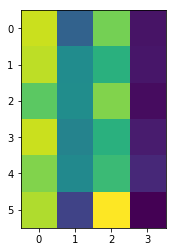

In [15]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 36.99%, category clustering: 29.59%
cluster: 1 --> top category: V-Bag, frequency of category (variety within cluster): 36.73%, category clustering: 53.65%
cluster: 2 --> top category: V-Bag, frequency of category (variety within cluster): 35.71%, category clustering: 12.16%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 42.03%, category clustering: 3.92%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.54%
cluster: 5 --> top category: V-Bag, frequency of category (variety within cluster): 50.00%, category clustering: 0.14%
Overall score (doesn't consider category clustering): 50.24%, weighted: 37.25%


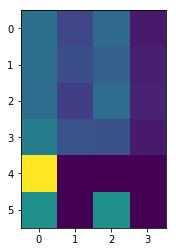

In [16]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

best weighted score: 38.99%, number of clusters: 9
log of best: 
cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 36.94%, category clustering: 29.05%
cluster: 1 --> top category: V-Pet, frequency of category (variety within cluster): 37.44%, category clustering: 12.73%
cluster: 2 --> top category: V-Bag, frequency of category (variety within cluster): 36.88%, category clustering: 53.38%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 44.87%, category clustering: 4.73%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 37.50%, category clustering: 1.62%
cluster: 5 --> top category: V-Pet, frequency of category (variety within cluster): 50.00%, category clustering: 0.62%
cluster: 6 --> top category: V-Pet, frequency of category (variety within cluster): 50.00%, category clustering: 0.31%
cluster: 7 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, catego

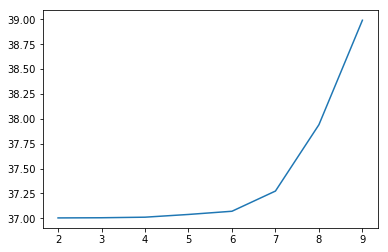

In [17]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

best weighted score: 37.72%, number of clusters: 7
log of best: 
cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 39.15%, category clustering: 24.86%
cluster: 1 --> top category: V-Bag, frequency of category (variety within cluster): 35.78%, category clustering: 62.03%
cluster: 2 --> top category: V-Bag, frequency of category (variety within cluster): 43.18%, category clustering: 5.14%
cluster: 3 --> top category: V-Bag, frequency of category (variety within cluster): 35.81%, category clustering: 7.16%
cluster: 4 --> top category: V-Auto, frequency of category (variety within cluster): 50.00%, category clustering: 0.67%
cluster: 5 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.54%
cluster: 6 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.14%
Overall score (doesn't consider category clustering): 57.70%, weighted: 37.72%


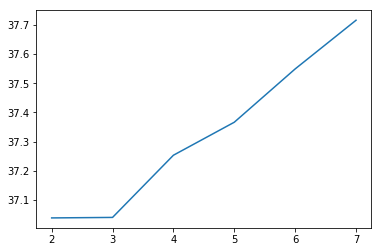

In [18]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

best weighted score: 38.60%, number of clusters: 7
log of best: 
cluster: 0 --> top category: V-Bag, frequency of category (variety within cluster): 37.06%, category clustering: 98.65%
cluster: 1 --> top category: V-Pet, frequency of category (variety within cluster): 50.00%, category clustering: 0.93%
cluster: 2 --> top category: V-Pet, frequency of category (variety within cluster): 66.67%, category clustering: 0.62%
cluster: 3 --> top category: V-Auto, frequency of category (variety within cluster): 50.00%, category clustering: 0.67%
cluster: 4 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.54%
cluster: 5 --> top category: V-Pet, frequency of category (variety within cluster): 100.00%, category clustering: 0.16%
cluster: 6 --> top category: V-Bag, frequency of category (variety within cluster): 100.00%, category clustering: 0.14%
Overall score (doesn't consider category clustering): 71.96%, weighted: 38.60%


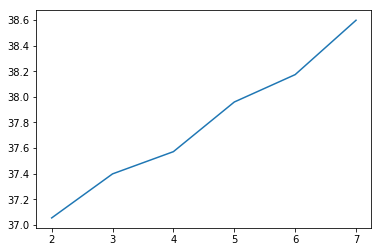

In [19]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [51]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['NumericAge'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
print(dict_numage_to_agecat)
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
my_perc = perc()

{0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}


In [53]:
my_perc.train(X, y, percentage=0.8, std=False, loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, max_iter=8000, it_interval=100, learning_rate='constant', eta0=1e-8,
          threshold_unbalanced=0.6, class_weight={2: 2.00, 1: 1.55, 0: 4.0})

run=1 tscore=0.306109 vscore=0.259358
run=2 tscore=0.325365 vscore=0.280749
run=3 tscore=0.337981 vscore=0.283422
run=4 tscore=0.347278 vscore=0.28877
run=5 tscore=0.353918 vscore=0.296791
run=6 tscore=0.357238 vscore=0.299465
run=7 tscore=0.358566 vscore=0.302139
run=8 tscore=0.36255 vscore=0.302139
run=9 tscore=0.36255 vscore=0.304813
run=10 tscore=0.36255 vscore=0.304813
run=11 tscore=0.363214 vscore=0.304813
run=12 tscore=0.363214 vscore=0.304813
run=13 tscore=0.363214 vscore=0.304813
run=14 tscore=0.363214 vscore=0.304813
run=15 tscore=0.363214 vscore=0.304813
run=16 tscore=0.363214 vscore=0.304813
run=17 tscore=0.363214 vscore=0.304813
run=18 tscore=0.363214 vscore=0.304813
run=19 tscore=0.363214 vscore=0.304813
run=20 tscore=0.363214 vscore=0.304813
run=21 tscore=0.363214 vscore=0.304813
run=22 tscore=0.363214 vscore=0.304813
run=23 tscore=0.363214 vscore=0.304813
run=24 tscore=0.363214 vscore=0.304813
run=25 tscore=0.363214 vscore=0.304813
run=26 tscore=0.363214 vscore=0.304813

KeyboardInterrupt: 

In [22]:
my_perc.predict(X,y)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [23]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['Urban'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
X = df[traffic_columns]
#unbalanced?
#np.bincount(y[~np.isnan(y)].astype(int))
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
my_perc = perc()

run=1 tscore=0.442835 vscore=0.403509
run=2 tscore=0.442835 vscore=0.403509
run=3 tscore=0.442835 vscore=0.403509
run=4 tscore=0.442835 vscore=0.403509
run=5 tscore=0.442835 vscore=0.403509
run=6 tscore=0.442835 vscore=0.403509
run=7 tscore=0.442835 vscore=0.403509
run=8 tscore=0.442835 vscore=0.403509
run=9 tscore=0.442835 vscore=0.403509
run=10 tscore=0.442835 vscore=0.403509
run=11 tscore=0.442835 vscore=0.403509
run=12 tscore=0.442835 vscore=0.403509
run=13 tscore=0.442835 vscore=0.403509
run=14 tscore=0.442835 vscore=0.403509
run=15 tscore=0.442835 vscore=0.403509
run=16 tscore=0.442835 vscore=0.403509
run=17 tscore=0.442835 vscore=0.403509
run=18 tscore=0.442835 vscore=0.403509
run=19 tscore=0.442835 vscore=0.403509
run=20 tscore=0.442835 vscore=0.403509
run=21 tscore=0.442835 vscore=0.403509
run=22 tscore=0.442835 vscore=0.403509
run=23 tscore=0.442835 vscore=0.403509
run=24 tscore=0.442835 vscore=0.403509
run=25 tscore=0.442835 vscore=0.403509
run=26 tscore=0.442835 vscore=0.40

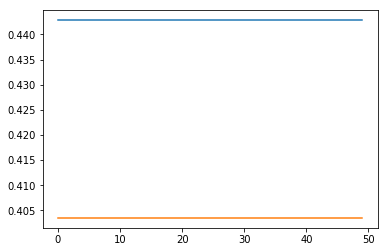

In [24]:
my_perc.train(X, y, percentage=0.8, std=False, loss='hinge', penalty='none', alpha=1e-4,
          power_t=0.5, max_iter=5000, it_interval=100, learning_rate='constant', eta0=1e-8,
          threshold_unbalanced=0.6, class_weight=None)

In [25]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_perc = perc()

Performed standardization
run=1 tscore=0.25475 vscore=0.265306
run=2 tscore=0.255613 vscore=0.265306
run=3 tscore=0.260794 vscore=0.268707
run=4 tscore=0.265112 vscore=0.272109
run=5 tscore=0.26943 vscore=0.278912
run=6 tscore=0.272021 vscore=0.289116
run=7 tscore=0.276339 vscore=0.292517
run=8 tscore=0.279793 vscore=0.295918
run=9 tscore=0.284974 vscore=0.295918
run=10 tscore=0.288428 vscore=0.29932
run=11 tscore=0.291019 vscore=0.302721
run=12 tscore=0.294473 vscore=0.309524
run=13 tscore=0.297927 vscore=0.316327
run=14 tscore=0.303109 vscore=0.312925
run=15 tscore=0.30829 vscore=0.316327
run=16 tscore=0.312608 vscore=0.319728
run=17 tscore=0.316062 vscore=0.319728
run=18 tscore=0.321244 vscore=0.323129
run=19 tscore=0.323834 vscore=0.329932
run=20 tscore=0.324698 vscore=0.333333
run=21 tscore=0.328152 vscore=0.333333
run=22 tscore=0.334197 vscore=0.340136
run=23 tscore=0.337651 vscore=0.336735
run=24 tscore=0.341105 vscore=0.346939
run=25 tscore=0.34456 vscore=0.353741
run=26 tscore

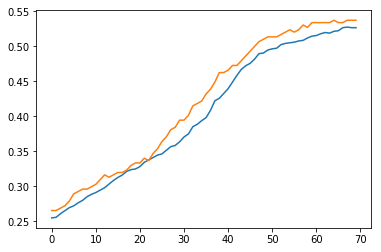

In [26]:
my_perc.train(X, y, percentage=0.8, std=True, loss='log', penalty='none', alpha=1e-4,
          power_t=0.5, max_iter=7000, it_interval=100, learning_rate='constant', eta0=1e-8,
          threshold_unbalanced=0.6, class_weight=None)

In [27]:
df = df_clean.copy()

X = df[traffic_columns]

y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
print(y.unique())
my_perc = perc()

['0.2' '0.1' '0.3' '0.0' nan '0.5' '0.6' '0.4' '0.7' '0.9' '0.8' '1.0']


run=1 tscore=0.0726172 vscore=0.0764331
run=2 tscore=0.0733737 vscore=0.0796178
run=3 tscore=0.0741301 vscore=0.0796178
run=4 tscore=0.0748865 vscore=0.0796178
run=5 tscore=0.0763994 vscore=0.0796178
run=6 tscore=0.0771558 vscore=0.0796178
run=7 tscore=0.0801815 vscore=0.0796178
run=8 tscore=0.080938 vscore=0.0828025
run=9 tscore=0.0816944 vscore=0.0828025
run=10 tscore=0.0839637 vscore=0.0859873
run=11 tscore=0.0847201 vscore=0.0859873
run=12 tscore=0.0877458 vscore=0.0859873
run=13 tscore=0.0907716 vscore=0.089172
run=14 tscore=0.0930408 vscore=0.0923567
run=15 tscore=0.0930408 vscore=0.0955414
run=16 tscore=0.0930408 vscore=0.0955414
run=17 tscore=0.0945537 vscore=0.0955414
run=18 tscore=0.0953101 vscore=0.0955414
run=19 tscore=0.0990923 vscore=0.101911
run=20 tscore=0.102118 vscore=0.101911
run=21 tscore=0.106657 vscore=0.105096
run=22 tscore=0.108926 vscore=0.10828
run=23 tscore=0.111195 vscore=0.10828
run=24 tscore=0.111195 vscore=0.117834
run=25 tscore=0.120272 vscore=0.117834
r

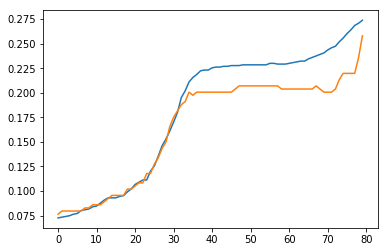

In [29]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, loss='log', penalty='none', alpha=1e-4,
          power_t=0.5, max_iter=8000, it_interval=100, learning_rate='constant', eta0=1e-6,
          threshold_unbalanced=0.6, class_weight=None)

### MLP

In [71]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_MLP = MLP()

Performed standardization
performed PCA, number of features: 13, explained variance for component:
 ['0.13', '0.11', '0.10', '0.08', '0.08', '0.08', '0.08', '0.07', '0.07', '0.07', '0.07', '0.06', '0.00']
epoch=0 loss=1.3025007508996251 tscore=0.6198979591836735 vscore=0.6413043478260869
epoch=1 loss=0.954709428752404 tscore=0.7397959183673469 vscore=0.7246376811594203
epoch=2 loss=0.8684875795423861 tscore=0.7653061224489796 vscore=0.7608695652173914
epoch=3 loss=0.7554265250740622 tscore=0.7729591836734694 vscore=0.7608695652173914
epoch=4 loss=0.6308654669735569 tscore=0.798469387755102 vscore=0.7789855072463768
epoch=5 loss=0.6056353661834872 tscore=0.8180272108843537 vscore=0.7971014492753623
epoch=6 loss=0.6045125592722693 tscore=0.8333333333333334 vscore=0.8007246376811594
epoch=7 loss=0.5875185065952769 tscore=0.8418367346938775 vscore=0.8079710144927537
epoch=8 loss=0.5304394332073776 tscore=0.8401360544217688 vscore=0.8260869565217391
epoch=9 loss=0.4681736621341568 tscore=0.

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=11 loss=0.5276559730643758 tscore=0.8324829931972789 vscore=0.8442028985507246
epoch=12 loss=0.4967872080168851 tscore=0.8469387755102041 vscore=0.8079710144927537
epoch=13 loss=0.41516687646158223 tscore=0.8767006802721088 vscore=0.8514492753623188
epoch=14 loss=0.4180881506235546 tscore=0.8469387755102041 vscore=0.8079710144927537
epoch=15 loss=0.46266672145734233 tscore=0.8707482993197279 vscore=0.8442028985507246
epoch=16 loss=0.38028869571824325 tscore=0.8571428571428571 vscore=0.8297101449275363
epoch=17 loss=0.46655558407548814 tscore=0.8316326530612245 vscore=0.8260869565217391
epoch=18 loss=0.45100574590578485 tscore=0.8579931972789115 vscore=0.8297101449275363
epoch=19 loss=0.4440460991177129 tscore=0.8579931972789115 vscore=0.8369565217391305
epoch=20 loss=0.43325929301773075 tscore=0.8852040816326531 vscore=0.8659420289855072
epoch=21 loss=0.4048855394040196 tscore=0.8435374149659864 vscore=0.8043478260869565
epoch=22 loss=0.5115010785519517 tscore=0.8409863945578231 

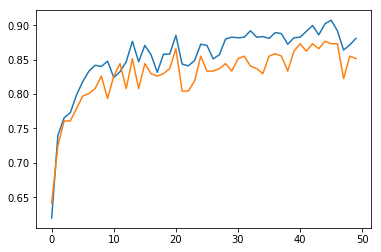

In [72]:
my_MLP.train(X, y, percentage=0.8, std=True, pca=None, epochs=50, threshold_unbalanced=0.6, 
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-1, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
             alpha = 0.0, tol = -1)

In [73]:
my_MLP.predict(X,y)

array(['Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'iOS', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'Android', 'Android',
       'Android', 'Android', 'Android', 'Android', 'And

In [78]:
a = df_clean['OS_clean'].copy()
d = dict()
for i in a:
    d[i] = d.get(i, 0) + 1
d

{'Android': 858, 'iOS': 568, nan: 548, 'other': 26}

# Logistic Regression

In [25]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_lr = LogisticRegression()

In [27]:
my_lr.train(X, y, percentage=0.8, std=True, pca=None, epochs=50, threshold_unbalanced=0.6, 
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

TypeError: __init__() got an unexpected keyword argument 'penalty'